### Import required packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf 
from tqdm import tqdm 

import matplotlib.pyplot as plt
%matplotlib inline 

### Data loading and EDA

In [2]:
data=np.load("olivetti_faces.npy") 
target=np.load("olivetti_faces_target.npy") 

In [3]:
np.unique(target) 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [4]:
target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [5]:
def show_40_distinct_people(images, ids):
    """
    This function will plot the images with unique ids. 
    """
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axarr=axarr.flatten()

    for id in ids:
        image_index=id*10
        axarr[id].imshow(images[image_index], cmap='gray')
        axarr[id].set_xticks([])
        axarr[id].set_yticks([])
    plt.suptitle("Some sample images from the dataset")

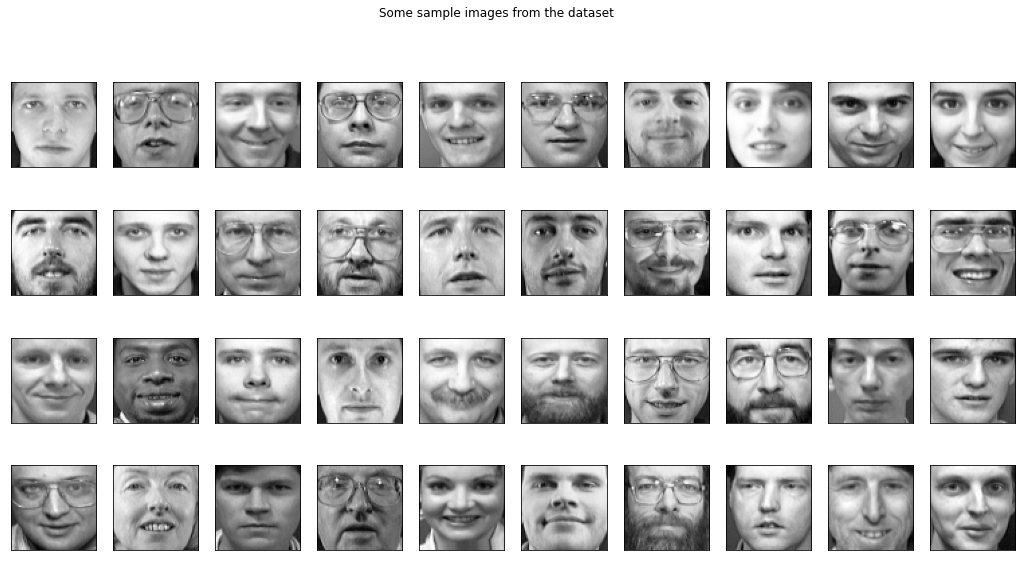

In [6]:
show_40_distinct_people(data, np.unique(target))

### Data Preparation

Negative pairs

In [7]:
### We will first generate two random numbers. 
### If these are not same and doesn't belongs to the same class, 
###           they will be pushed under a single datapoint and labelled as 0.

counter = 0
total_sample_size = 10000
x_not_geuine_pair = np.zeros([total_sample_size, 2, 1, 64, 64]) # 2 is for pairs
y_not_genuine = np.zeros([total_sample_size, 1])


for i in tqdm(range(10000)):
  index1 = np.random.randint(399)
  index2 = np.random.randint(399)

  if index1 != index2:
    if index1/10 == index2/10:
      while index1 == index2:  
        index1 = np.random.randint(399)
        index2 = np.random.randint(399)
      x_not_geuine_pair[counter, 0, 0, :, :] = data[index1]
      x_not_geuine_pair[counter, 1, 0, :, :] = data[index2]
      y_not_genuine[counter, 0] = 0
      counter += 1
    else:
      # print("Hi --- ", index1, index2)
      x_not_geuine_pair[counter, 0, 0, :, :] = data[index1]
      x_not_geuine_pair[counter, 1, 0, :, :] = data[index2]
      y_not_genuine[counter, 0] = 0
      counter += 1
  else:
    while index1 == index2:  
      index1 = np.random.randint(399)
      index2 = np.random.randint(399)
    x_not_geuine_pair[counter, 0, 0, :, :] = data[index1]
    x_not_geuine_pair[counter, 1, 0, :, :] = data[index2]
    y_not_genuine[counter, 0] = 0
    counter += 1

  # print(index1, index2)

100%|██████████| 10000/10000 [00:00<00:00, 38952.28it/s]


In [8]:
x_not_geuine_pair[0] 

array([[[[0.28512397, 0.23553719, 0.23553719, ..., 0.61157024,
          0.60743803, 0.59090906],
         [0.24793388, 0.2107438 , 0.26033059, ..., 0.61983472,
          0.60330576, 0.58677685],
         [0.23553719, 0.20247933, 0.23966943, ..., 0.61983472,
          0.59917355, 0.57851237],
         ...,
         [0.38842976, 0.38842976, 0.39256197, ..., 0.12396694,
          0.16115703, 0.21900827],
         [0.40909091, 0.41322315, 0.41322315, ..., 0.12809917,
          0.15289256, 0.23553719],
         [0.40495867, 0.40909091, 0.41735536, ..., 0.12809917,
          0.14876033, 0.23966943]]],


       [[[0.54132229, 0.58677685, 0.6404959 , ..., 0.54545456,
          0.55371898, 0.55785125],
         [0.55371898, 0.61570245, 0.6570248 , ..., 0.57438016,
          0.58264464, 0.57851237],
         [0.57851237, 0.65289259, 0.67768598, ..., 0.57024795,
          0.60330576, 0.59917355],
         ...,
         [0.12809917, 0.13636364, 0.13636364, ..., 0.09090909,
          0.11570248, 0

Positive pairs

In [9]:
### We will first generate three random numbers(index1, ind1, ind2). 
###  (index1*10 + ind1) and (index1*10 + ind1)  belongs to the same class, 
###           they will be pushed under a single datapoint and labelled as 1 indicating same class.

total_sample_size = 10000
x_geuine_pair = np.zeros([total_sample_size, 2, 1, 64, 64]) # 2 is for pairs
y_genuine = np.zeros([total_sample_size, 1])

counter = 0

for i in tqdm(range(10000)):
  index1 = np.random.randint(39)
  ind1 = 0
  ind2 = 0
  while ind1 == ind2:
    ind1 = np.random.randint(9)
    ind2 = np.random.randint(9)

  x_geuine_pair[counter, 0, 0, :, :] = data[index1*10 + ind1]
  x_geuine_pair[counter, 1, 0, :, :] = data[index1*10 + ind1]
  y_genuine[counter, 0] = 1
  counter += 1

  # print(index1*10 + ind1, index1*10 + ind2)
  

100%|██████████| 10000/10000 [00:00<00:00, 32818.46it/s]


In [10]:
y_genuine[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [11]:
### Concatenating positve and negative datapoints

X = np.concatenate([x_geuine_pair, x_not_geuine_pair], axis=0)
Y = np.concatenate([y_genuine, y_not_genuine], axis=0)

### Save pairs data

In [12]:
## Saving data

with open('Pairs data.npy', 'wb') as f:
    np.save(f, X)

In [13]:
## Saving data

with open('Labels data.npy', 'wb') as f:
    np.save(f, Y)

### Data splitting

In [14]:
## Splitting data into train and test. train --> 80% ==> 16000 points,   test --> 20% ==> 4000 points
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, shuffle=True)

In [15]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16000, 2, 1, 64, 64), (16000, 1), (4000, 2, 1, 64, 64), (4000, 1))

### Model, loss, training

In [16]:
def build_base_network(input_shape):
  """
  This function will build a CNN model and returns it.
  """
    model = Sequential()
    model.add(Conv2D(6,(3, 3), activation='relu',padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(6, (3, 3),padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    return model 

In [17]:
input_dim = (64, 64, 1)

left_input = Input(shape=input_dim)
right_input = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(left_input)
feat_vecs_b = base_network(right_input) 

In [18]:
from tensorflow.keras import backend as K 


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

### Constructing a layer to calculate distance from scratch.
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

input=[left_input, right_input] ## Input layer for siamese model
output=distance  ## Output layer for siamese model

model = Model(input, output) ## Defining siamese

In [19]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer='adam')  ## Compiling the siamese model

In [20]:
x_train.shape, x_test.shape

((16000, 2, 1, 64, 64), (4000, 2, 1, 64, 64))

In [21]:
left_train_images = x_train[:, 0] 
right_train_images = x_train[:, 1]  

left_model=np.reshape(left_train_images,(16000,64,64,1))
right_model=np.reshape(right_train_images,(16000,64,64,1))

model.summary()  ### Printing the summary of siamese model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 50)           203576      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

Training the model

In [22]:
### Training the model

history = model.fit([[left_model, right_model]], y_train, batch_size=128, verbose=2, epochs=200) 

Epoch 1/200
125/125 - 4s - loss: 0.1723 - 4s/epoch - 34ms/step
Epoch 2/200
125/125 - 2s - loss: 0.0701 - 2s/epoch - 16ms/step
Epoch 3/200
125/125 - 2s - loss: 0.0517 - 2s/epoch - 16ms/step
Epoch 4/200
125/125 - 2s - loss: 0.0436 - 2s/epoch - 16ms/step
Epoch 5/200
125/125 - 2s - loss: 0.0381 - 2s/epoch - 16ms/step
Epoch 6/200
125/125 - 2s - loss: 0.0362 - 2s/epoch - 16ms/step
Epoch 7/200
125/125 - 2s - loss: 0.0335 - 2s/epoch - 16ms/step
Epoch 8/200
125/125 - 2s - loss: 0.0325 - 2s/epoch - 16ms/step
Epoch 9/200
125/125 - 2s - loss: 0.0301 - 2s/epoch - 16ms/step
Epoch 10/200
125/125 - 2s - loss: 0.0285 - 2s/epoch - 16ms/step
Epoch 11/200
125/125 - 2s - loss: 0.0279 - 2s/epoch - 16ms/step
Epoch 12/200
125/125 - 2s - loss: 0.0268 - 2s/epoch - 16ms/step
Epoch 13/200
125/125 - 2s - loss: 0.0260 - 2s/epoch - 16ms/step
Epoch 14/200
125/125 - 2s - loss: 0.0251 - 2s/epoch - 16ms/step
Epoch 15/200
125/125 - 2s - loss: 0.0247 - 2s/epoch - 17ms/step
Epoch 16/200
125/125 - 2s - loss: 0.0236 - 2s/epo

Plotting the loss

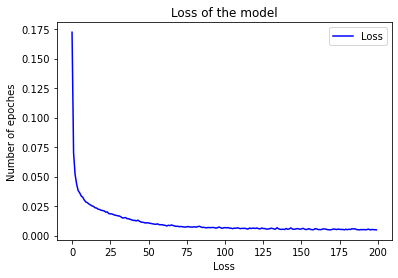

In [23]:
### Plotting the model loss 

loss = history.history['loss']
epochs = range(0, len(loss))

plt.figure()
plt.plot(epochs, loss, 'b-', label = 'Loss')
plt.title('Loss of the model')
plt.xlabel('Loss')
plt.ylabel('Number of epoches')
plt.legend()
plt.savefig("Loss of the model", dpi = 500)

### Save model

In [24]:
model.save("Siamese_model_trained") 

INFO:tensorflow:Assets written to: Siamese_model_trained/assets


In [25]:
model.save("Siamese_model_trained__.h5") 

### Making predictions

In [26]:
left_test_images = x_test[:, 0]
right_test_images = x_test[:, 1] 

left_test_X=np.reshape(left_test_images,(4000, 64, 64, 1))
right_test_X=np.reshape(right_test_images,(4000, 64, 64, 1)) 

left_test_X.shape

(4000, 64, 64, 1)

In [27]:
### To make predictions

pred = model.predict([left_test_X, right_test_X])

In [28]:
pred

array([[1.2615484 ],
       [2.2187908 ],
       [0.9394709 ],
       ...,
       [0.98933583],
       [2.039766  ],
       [0.        ]], dtype=float32)

### Checking Predictions

In [29]:
for i in range(len(pred)):
  print(pred[i], y_test[i])

[1.2615484] [0.]
[2.2187908] [0.]
[0.9394709] [0.]
[0.] [1.]
[1.3576124] [0.]
[1.32099] [0.]
[0.99931693] [0.]
[1.0030156] [0.]
[1.9708374] [0.]
[1.629069] [0.]
[0.] [1.]
[2.9131746] [0.]
[1.588331] [0.]
[0.] [1.]
[2.072513] [0.]
[0.] [1.]
[0.02322114] [0.]
[1.6446944] [0.]
[0.] [1.]
[0.] [1.]
[0.] [1.]
[2.1877472] [0.]
[0.] [1.]
[2.0051608] [0.]
[0.] [1.]
[0.] [1.]
[1.3744731] [0.]
[1.7644556] [0.]
[1.9109062] [0.]
[0.] [1.]
[0.] [1.]
[2.902471] [0.]
[1.7099342] [0.]
[1.6651655] [0.]
[0.] [1.]
[1.9062198] [0.]
[0.] [1.]
[0.] [1.]
[0.] [1.]
[0.] [1.]
[1.2097801] [0.]
[0.] [1.]
[1.7055831] [0.]
[0.] [1.]
[0.] [1.]
[1.3862962] [0.]
[1.3129627] [0.]
[1.8868057] [0.]
[0.] [1.]
[2.5221443] [0.]
[0.] [1.]
[2.0896394] [0.]
[2.2070765] [0.]
[0.] [1.]
[0.] [1.]
[0.] [1.]
[1.4706445] [0.]
[0.] [1.]
[1.6111323] [0.]
[0.] [1.]
[1.7405704] [0.]
[0.] [1.]
[0.] [1.]
[2.2917423] [0.]
[0.] [1.]
[0.] [1.]
[0.] [1.]
[1.8567494] [0.]
[0.] [1.]
[0.] [1.]
[1.0214419] [0.]
[0.17954816] [0.]
[1.9942559] [0.]


### Calculate accuracy

In [30]:
### Calculating accuracy of the model using the threshold == 0.5 

correctly_classified = 0
predictions = pred
for i in range(len(predictions)):
  if predictions[i] < 0.5 and y_test[i] == 1:
    correctly_classified += 1
  elif predictions[i] >= 0.5 and y_test[i] == 0:
    correctly_classified += 1
  else:
    pass 

print("Accuracy of the model is : ",  correctly_classified/len(predictions))

Accuracy of the model is :  0.9855
